In [28]:
import models
import audio_utils
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import librosa
import torch.nn as nn
import os
import random
import pandas as pd
import numpy as np

In [29]:
model = models.BL_Decoder_Classifier()
model.load_state_dict(torch.load('models/AE_classifier_model_01.pt'))

<All keys matched successfully>

In [34]:
encoder = models.logMelAE()
encoder.load_state_dict(torch.load('models/logMelAE_model_02.pt'))

<All keys matched successfully>

In [33]:
#rand_fn = '../speechRemoval/fin_dataframe.csv'
rand_fn = 'new_NIGENS_df.csv'
df = pd.read_csv(rand_fn)

f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
snr = [5]

noise = audio_utils.add_two_noise([f1,f2], snr)
feats_ = audio_utils.get_random_audioFeatures(noise)

f1, f2

('../audioData/NIGENS/NIGENS/femaleScream/219868__polmdx__old-woman-scream.wav',
 '../audioData/NIGENS/NIGENS/phone/Telephone_DIGIP02-63.wav')

In [32]:
with torch.no_grad():
    repres = encoder.encoder(feats_)
    out = model(repres)
    out = torch.round(out)
print(out)

tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]])


In [37]:
labels_list = df['label1'].unique()
labels_list.sort()

lab_key = [i for i in range(0, len(labels_list))]
lab_dict = {labels_list[i]:lab_key[i] for i in range(0, len(labels_list))}
lab_dict['silence'] = 14

In [43]:
labels = [0 for i in range(0,15)]
len(labels) == len(lab_dict)

True

In [44]:
class sedDataset(Dataset):

    def __init__(self, dataframe):
        self.dataset_df = dataframe

    def __len__(self):
        return len(self.dataset_df)
    
    def __getitem__(self, index):

        fil_list = [self.dataset_df.iloc[index, 0], self.dataset_df.iloc[index, 1]]
        lab1 = lab_dict[self.dataset_df.iloc[index, 2]]
        lab2 = lab_dict[self.dataset_df.iloc[index, 3]]
        
        noise = audio_utils.add_two_noise(fil_list, [5])
        feats = audio_utils.get_random_audioFeatures(noise)
        
        if torch.isnan(noise).any():
            noise = torch.zeros(noise.shape)
            lab1 = lab_dict['silence']
            lab2 = lab_dict['silence']
            feats = torch.zeros(feats.shape)
            
               
        labels = [0 for i in range(0,15)]
        labels[lab1] = 1
        labels[lab2] = 1
        labels = torch.Tensor(labels)
        
        return feats, labels

In [45]:
split = (int)(len(df)*0.8)

train_dataset = sedDataset(df[0:split])
test_dataset = sedDataset(df[split:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [48]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class AEDClassifier(nn.Module):

    def __init__(self):
        super(AEDClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(858, 200),
            nn.ReLU(),
            nn.Linear(200, 15)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.classifier(x)
        y = self.sigmoid(x)

        return y

In [49]:
sas = torch.rand([16,10,63])

AEDClassifier()(sas)

tensor([[0.4878, 0.5069, 0.5038, 0.4900, 0.4961, 0.4953, 0.4958, 0.4990, 0.5140,
         0.5004, 0.5039, 0.4983, 0.4886, 0.5074, 0.5039]],
       grad_fn=<SigmoidBackward0>)

In [50]:
sed_classifier = AEDClassifier()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

#loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(sed_classifier.parameters(), lr=0.001)

In [51]:
import statistics

sed_classifier = sed_classifier.to(device)
encoder = encoder.to(device)

epochs = 10

for epoch in range(0, epochs):
    loc_list = []
    
    for data in train_loader:
        sed_classifier.train()
        optimizer.zero_grad()
        inputs, labes = data

        inputs = inputs.to(device)
        encoder.eval()
        with torch.no_grad():
            preds = encoder.encoder(inputs)
        input = preds
        if not torch.isnan(input).any():
            labes = labes.to(device)

            output = sed_classifier(input)
            #print(output.shape, labes.shape)
            loss = loss_fn(output, labes)

            if not torch.isnan(loss).any():
                loss.backward()
                optimizer.step()
                loc_list.append(loss.item())    

    print(f"Epoch [{epoch+1}/{epochs}] Loss: [{statistics.mean(loc_list)}]")

Epoch [1/10] Loss: [0.2710163162834942]
Epoch [2/10] Loss: [0.14383303261827676]
Epoch [3/10] Loss: [0.0868938651739154]
Epoch [4/10] Loss: [0.05759470409015194]
Epoch [5/10] Loss: [0.045755484313995114]
Epoch [6/10] Loss: [0.038500604006039794]
Epoch [7/10] Loss: [0.03286746108191437]
Epoch [8/10] Loss: [0.027707441074126107]
Epoch [9/10] Loss: [0.024660150957970473]
Epoch [10/10] Loss: [0.02341008017578133]


In [55]:
## Evaluation
import sklearn.metrics
encoder = encoder.to('cpu')
sed_classifier = sed_classifier.to('cpu')
y_true = []
y_preds = []

for data in test_loader:

    input, label = data
    y_true.append(label.numpy())

    with torch.no_grad():
        repr = encoder.encoder(input)
        out = sed_classifier(repr)
        y_preds.append(torch.round(out).numpy())

#print(sklearn.metrics.accuracy_score(y_true, y_preds))

In [56]:
yy = np.concatenate(y_true)
yp = np.concatenate(y_preds)

'''conf_mat = sklearn.metrics.multilabel_confusion_matrix(yy, yp)
for i, confusion_matrix in enumerate(conf_mat):
    print(f'Confusion Matrix for Label {i}:')
    print(confusion_matrix)
    print('\n')
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [62]:
labels_list = np.append(labels_list, 'silence')
labels_list

array(['alarm', 'baby', 'crash', 'dog', 'engine', 'femaleScream',
       'femaleSpeech', 'fire', 'footsteps', 'knock', 'maleScream',
       'maleSpeech', 'phone', 'piano', 'silence'], dtype=object)

In [63]:
save_dict = sklearn.metrics.classification_report(yy, yp, target_names=labels_list, output_dict=True)

/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [64]:
report_df = pd.DataFrame(save_dict).transpose()

report_df.to_csv('results/AE_fullClassifier_model_01_results.csv', index=False)

In [66]:
report_df

,precision,recall,f1-score,support
alarm,0.849372,0.867521,0.858351,234.0
baby,0.900474,0.848214,0.873563,224.0
crash,0.953608,0.745968,0.837104,248.0
dog,0.868263,0.714286,0.783784,203.0
engine,0.790123,0.927536,0.853333,207.0
femaleScream,0.884444,0.884444,0.884444,225.0
femaleSpeech,0.968750,0.953846,0.961240,260.0
fire,0.921788,0.705128,0.799031,234.0
footsteps,0.915888,0.841202,0.876957,233.0
knock,0.880383,0.814159,0.845977,226.0


In [65]:
import json

with open('results/AE_fullClassifier_model_01_results.json', 'w') as fp:
    json.dump(save_dict, fp, indent=2)

In [22]:
with open('results/AE_Classifier_model_01_results.json', 'r') as fp:
    data = json.load(fp)

data

{'alarm': {'precision': 0.9,
  'recall': 0.8411214953271028,
  'f1-score': 0.8695652173913043,
  'support': 107.0},
 'baby': {'precision': 0.8235294117647058,
  'recall': 0.8484848484848485,
  'f1-score': 0.8358208955223881,
  'support': 99.0},
 'crash': {'precision': 0.7906976744186046,
  'recall': 0.7472527472527473,
  'f1-score': 0.7683615819209039,
  'support': 91.0},
 'dog': {'precision': 0.7662337662337663,
  'recall': 0.6145833333333334,
  'f1-score': 0.6820809248554913,
  'support': 96.0},
 'engine': {'precision': 0.8571428571428571,
  'recall': 0.8648648648648649,
  'f1-score': 0.8609865470852017,
  'support': 111.0},
 'fire': {'precision': 0.8620689655172413,
  'recall': 0.7211538461538461,
  'f1-score': 0.7853403141361256,
  'support': 104.0},
 'footsteps': {'precision': 0.7640449438202247,
  'recall': 0.7311827956989247,
  'f1-score': 0.7472527472527474,
  'support': 93.0},
 'knock': {'precision': 0.9032258064516129,
  'recall': 0.7924528301886793,
  'f1-score': 0.844221105

In [67]:
f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
print(f1,f2)
noise = audio_utils.add_two_noise([f1,f2], [5])
featss = audio_utils.get_random_audioFeatures(noise)

encoder = encoder.cpu()
encoder.eval()
with torch.no_grad():
    repres = encoder.encoder(featss)

sed_classifier = sed_classifier.cpu()
sed_classifier.eval()
with torch.no_grad():
    out = sed_classifier(repres)

print((torch.round(out)), lab_dict)

../audioData/NIGENS/NIGENS/femaleScream/220312__ellenskellington__womanshout.wav ../audioData/NIGENS/NIGENS/knock/DOOR-KNOCK_GEN-HDF-09717.wav
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]) {'alarm': 0, 'baby': 1, 'crash': 2, 'dog': 3, 'engine': 4, 'femaleScream': 5, 'femaleSpeech': 6, 'fire': 7, 'footsteps': 8, 'knock': 9, 'maleScream': 10, 'maleSpeech': 11, 'phone': 12, 'piano': 13, 'silence': 14}


/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


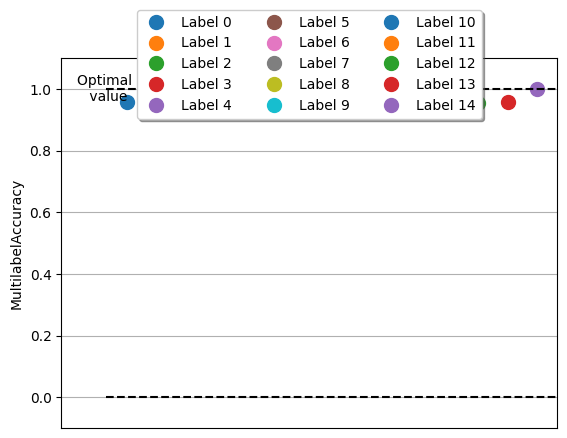

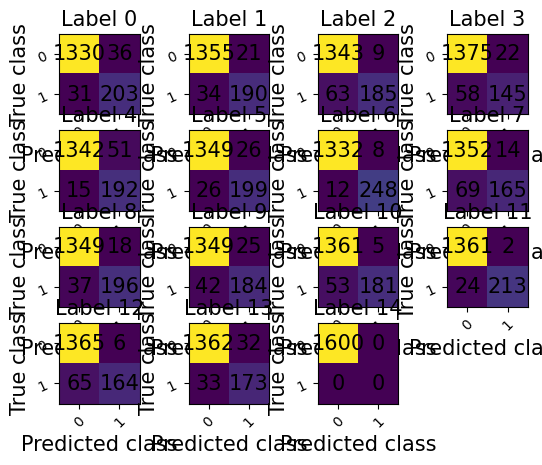

In [68]:
import torchmetrics
acc_list = []
sed_classifier = sed_classifier.to('cpu')
encoder = encoder.to('cpu')

multi_lab_acc = torchmetrics.classification.MultilabelAccuracy(num_labels=len(lab_dict), average=None)
conf_mat = torchmetrics.classification.MultilabelConfusionMatrix(num_labels=len(lab_dict))
for data in test_loader:

    sed_classifier.eval()
    encoder.eval()
    inpu, labs = data

    with torch.no_grad():
        repr = encoder.encoder(inpu)
        out_ = sed_classifier(repr)
        out_ = torch.round(out_)
    out_ = out_.to('cpu', torch.int)
    labs = labs.to('cpu', torch.int)
    multi_lab_acc.update(out_, labs)
    conf_mat.update(out_, labs)

fig1, ax1 = multi_lab_acc.plot()
fig2, ax2 = conf_mat.plot()

In [69]:
# AE_classifier_model_00.pt: 10 epochs, conf00
# AE_classifier_model_01.pt: 20 epochs, conf00
torch.save(sed_classifier.state_dict(), 'models/AE_fullclassifier_model_00.pt')